<h3>Loading Data</h3>

In [26]:
#importing modules
import pandas as pd
import os
import numpy as np

os.chdir('..')
papers = pd.read_csv('D:\DEVELOPEMENT\AES-Kaggle\Research\LDA\data\papers.csv')

papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


<h3>Data cleaning</h3>

In [27]:
#remove columns
# axis=1 ensures that columns are dropped
#.sample(100) makes sure 100 random rows are selected from papers
papers = papers.drop(columns=['id','event_type', 'pdf_name'], axis=1).sample(100)

papers.head()

,year,title,abstract,paper_text
4782,1991,Adaptive Elastic Models for Hand-Printed Chara...,Abstract Missing,Adaptive Elastic Models for Hand-Printed\nChar...
2768,1990,Connectionist Implementation of a Theory of Ge...,Abstract Missing,Connectionist Implementation of a Theory of Ge...
3551,2011,Demixed Principal Component Analysis,"In many experiments, the data points collected...",Demixed Principal Component Analysis\n\nRanulf...
3227,2010,Self-Paced Learning for Latent Variable Models,Latent variable models are a powerful tool for...,Self-Paced Learning for Latent Variable Models...
4042,2012,Topic-Partitioned Multinetwork Embeddings,We introduce a joint model of network content ...,Topic-Partitioned Multinetwork Embeddings\n\nP...


In [28]:
# remove punctuation from paper_text and make lowercase

# import regular expression library
import re

# Removing punctuation
papers['paper_text_processed']=papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert tiles to lowercase
papers['paper_text_processed']=papers['paper_text_processed'].map(lambda x: x.lower())

papers['paper_text_processed'].head()

4782    adaptive elastic models for hand-printed\nchar...
2768    connectionist implementation of a theory of ge...
3551    demixed principal component analysis\n\nranulf...
3227    self-paced learning for latent variable models...
4042    topic-partitioned multinetwork embeddings\n\np...
Name: paper_text_processed, dtype: object

<h3>Exploratory analysis</h3>

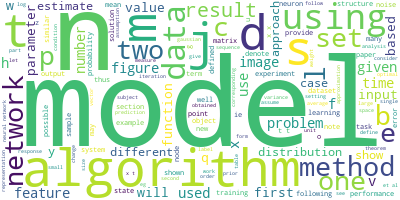

In [35]:
# Using wordcloud package to get a visual representation of the most common words
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

<h3>Preparing data for LDA analysis</h3>

In [43]:
# Transforming the textual data in a format that will serve as an input for training LDA model

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
# we need to add some more stopwords =>
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    # function to convert sentences to words
    # deacc removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    # Function to stop stopwords
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = papers.paper_text_processed.values.tolist()

data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['adaptive', 'elastic', 'models', 'hand', 'printed', 'character', 'recognition', 'geoffrey', 'hinton', 'christopher', 'williams', 'michael', 'revow', 'department', 'computer', 'science', 'university', 'toronto', 'toronto', 'ontario', 'canada', 'la', 'abstract', 'hand', 'printed', 'digits', 'modeled', 'splines', 'governed', 'control']


In [44]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
# Each tuple represents a word in the document along with its frequency.
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 5), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 11), (12, 2), (13, 6), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 5), (20, 4), (21, 2), (22, 2), (23, 1), (24, 2), (25, 2), (26, 1), (27, 1), (28, 1), (29, 3)]


<h3>LDA model training</h3>

In [45]:
from pprint import pprint

# Number of topics = 10
num_topics = 10

# Build LDA Model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.006*"learning" + 0.005*"model" + 0.005*"algorithm" + 0.005*"set" + '
  '0.005*"data" + 0.004*"time" + 0.004*"using" + 0.004*"one" + '
  '0.004*"function" + 0.003*"number"'),
 (1,
  '0.005*"model" + 0.005*"learning" + 0.005*"one" + 0.005*"data" + 0.004*"set" '
  '+ 0.004*"using" + 0.004*"algorithm" + 0.004*"function" + 0.003*"time" + '
  '0.003*"network"'),
 (2,
  '0.008*"data" + 0.007*"model" + 0.006*"time" + 0.004*"learning" + '
  '0.004*"set" + 0.004*"algorithm" + 0.004*"training" + 0.004*"function" + '
  '0.004*"one" + 0.004*"using"'),
 (3,
  '0.007*"data" + 0.006*"algorithm" + 0.004*"set" + 0.004*"problem" + '
  '0.004*"model" + 0.004*"function" + 0.004*"two" + 0.003*"information" + '
  '0.003*"one" + 0.003*"learning"'),
 (4,
  '0.007*"model" + 0.006*"learning" + 0.006*"data" + 0.005*"algorithm" + '
  '0.004*"time" + 0.004*"using" + 0.004*"set" + 0.003*"error" + 0.003*"two" + '
  '0.003*"function"'),
 (5,
  '0.008*"data" + 0.005*"algorithm" + 0.005*"using" + 0.004*"learni

<h3>Analyzing LDA model results</h3>

In [51]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()

file_name = str(num_topics) +'.html'
LDAvis_data_filepath = os.path.join('D:\\DEVELOPEMENT\\AES-Kaggle\\Research\LDA\\results\\ldavis_prepared_' + str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'D:\\DEVELOPEMENT\\AES-Kaggle\\Research\LDA\\results\\ldavis_prepared_'+ file_name)
LDAvis_prepared

<>:8: DeprecationWarning: invalid escape sequence '\L'
<>:18: DeprecationWarning: invalid escape sequence '\L'
<>:8: DeprecationWarning: invalid escape sequence '\L'
<>:18: DeprecationWarning: invalid escape sequence '\L'
C:\Users\HP\AppData\Local\Temp\ipykernel_21928\3791848985.py:8: DeprecationWarning: invalid escape sequence '\L'
  LDAvis_data_filepath = os.path.join('D:\\DEVELOPEMENT\\AES-Kaggle\\Research\LDA\\results\\ldavis_prepared_' + str(num_topics))
C:\Users\HP\AppData\Local\Temp\ipykernel_21928\3791848985.py:18: DeprecationWarning: invalid escape sequence '\L'
  pyLDAvis.save_html(LDAvis_prepared, 'D:\\DEVELOPEMENT\\AES-Kaggle\\Research\LDA\\results\\ldavis_prepared_'+ file_name)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.009172  0.003521       1        1  13.720957
2      0.001359 -0.005472       2        1  13.245109
4     -0.006285 -0.005059       3        1  13.163535
3     -0.003481  0.005986       4        1  11.766140
5     -0.001205  0.004720       5        1  11.618340
6     -0.002787  0.002691       6        1  11.306396
0     -0.004372  0.001370       7        1   7.235060
9      0.004395 -0.000702       8        1   6.386481
1      0.004359 -0.003936       9        1   6.374750
7     -0.001156 -0.003120      10        1   5.183231, topic_info=             Term         Freq        Total Category  logprob  loglift
397      learning  1132.000000  1132.000000  Default  30.0000  30.0000
494           one   807.000000   807.000000  Default  29.0000  29.0000
447         model  1341.000000  1341.000000  Default  28.0000  28.0000
761         using   914.000000   914.000000  Default  27.0000  27.0000
13      algorithm  1051.000000  1051.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
271      function    30.498135   816.282374  Topic10  -5.9757  -0.3274
432        matrix    24.754661   548.385440  Topic10  -6.1844  -0.1382
287         given    23.777618   498.591679  Topic10  -6.2247  -0.0833
471        neural    24.576438   596.481023  Topic10  -6.1916  -0.2295
187  distribution    23.549902   486.902625  Topic10  -6.2343  -0.0692

[853 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
16067      1  0.222957   abbot
16067      2  0.222957   abbot
16067      4  0.222957   abbot
16067      6  0.222957   abbot
16067      8  0.222957   abbot
...      ...       ...     ...
12761      5  0.181896     ykt
12761      6  0.181896     ykt
12761     10  0.181896     ykt
13539      2  0.264380  yousef
13539      3  0.264380  yousef

[4078 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 3, 5, 4, 6, 7, 1, 10, 2, 8])